# Fruit Classification using Transfer Learning

## Code to suppress warnings

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

#### Required Libraries

In [2]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install numpy

## Preparing our Dataset

#### Set Dataset Paths
If we are in <strong>Google Colab</strong>. We need to mount our Google Drive to access the 'dataset' folder.
Remember: You will receive a Security Alert on your respective GMail Account. Just Ignore...

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Now, we can set dataset paths. All we need to do is that copy the paths of the respective folders and store them in Python Variables.

In [4]:
train_dir = "dataset/train"
test_dir = "dataset/test"
val_dir = "dataset/valid"

#### Set up Data Generators for training, testing and validation with augmentation
Data Generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better.<br>Remember! Data Augmentation is not applied on 'test' and 'validation' directories. Only rescaling is done.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

#### Load Images from directories

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (64, 64),
    batch_size = 16,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (64, 64),
    batch_size = 16,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (64, 64),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


##### Explanation:
- `train_datagen: ` Applies rescaling and augmentation (rotation, zoom, horizontal flip) to make model more robust
- `test_datagen and val_datagen: ` Only rescale images for testing and validation
- `flow_from_directory: ` Loads images from specified folders into batches for training, testing and validation

## Defining Model using VGG16 with Custom Layers

In [7]:
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64 ,64, 3))

# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

##### Explanation:
- `base_model: ` Loads VGG16, excluding its dense layers (`include_top=False`)
- `for layer in base_model.layers: ` Freezes VGG16 layers to retain pre-trained weights
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning

#### Compile the Model

In [8]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

##### Explanation:
- `categorical_crossentropy: ` Used because it a multi-class classification model
- `adam: ` Adaptive Learning Rate Optimizer
- `metrics=['accuracy']: ` Tracks model's accuracy

## Training the model

In [9]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 1e-6, verbose = 1)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [lr_scheduler, early_stopping]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.2874 - loss: 2.0368 - val_accuracy: 0.4450 - val_loss: 1.3409 - learning_rate: 0.0010
Epoch 2/10


C:\Users\Lakshya Saxena\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4270 - loss: 1.4995 - val_accuracy: 0.5000 - val_loss: 1.2332 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4130 - loss: 1.4478 - val_accuracy: 0.4100 - val_loss: 1.2882 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4615 - loss: 1.4169 - val_accuracy: 0.5200 - val_loss: 1.1800 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4669 - loss: 1.3030 - val_accuracy: 0.5200 - val_loss: 1.1335 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5131 - loss: 1.2227 - val_accuracy: 0.5100 - val_loss: 1.2154 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5346 - loss: 1.2216 - val_accuracy: 0.5650 - val_loss: 1.0623 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5091 - loss: 1.3101 - val_accuracy: 0.5400 - va

##### Explanation:
- `ReduceLRPlateau: ` Reduces the rate validation loss plateaus, allowing better optimization
- `EarlyStopping: ` Stops training when validation loss no longer improves, preventing overfitting
- `model.fit: ` Trains the model on the `train_generator` and evaluates on `val_generator` each epoch

## Fine Tune the model by unfreezing specific layers of VGG16
<strong>Explanation: </strong>Fine-tune by unfreezing a few layers in the VGG16 base model to allow learning on fruit-specific features.

In [10]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
  layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
  metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
  train_generator,
  epochs = 10,
  validation_data = val_generator,
  steps_per_epoch = steps_per_epoch,  # Reduced steps per epoch
  validation_steps = validation_steps,  # Reduced validation steps
  callbacks = [lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5307 - loss: 1.2194 - val_accuracy: 0.5900 - val_loss: 1.0130 - learning_rate: 1.0000e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5457 - loss: 1.2086 - val_accuracy: 0.6100 - val_loss: 0.9855 - learning_rate: 1.0000e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5839 - loss: 1.0872 - val_accuracy: 0.6200 - val_loss: 0.9565 - learning_rate: 1.0000e-05
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5497 - loss: 1.1717 - val_accuracy: 0.6350 - val_loss: 0.9071 - learning_rate: 1.0000e-05
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5431 - loss: 1.1276 - val_accuracy: 0.6050 - val_loss: 0.9299 - learning_rate: 1.0000e-05
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5749 - loss: 1.0506
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step -

##### Explanation:
- `for layer in base_model.layers[-5:]: ` Unfreezes the last 5 layers to allow fine-tuning.
- Unfreezing fewer layers is faster and prevents overfitting on small datasets.
- `RMSprop(learning_rate=1e-5): ` Optimizer with a lower learning rate to fine-tune carefully without drastic weight changes.

## Evaluate the model on the test set and display accuracy

In [11]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6834 - loss: 0.9247  
Test Accuracy: 0.68


## Visualize training performance with accuracy and loss curves
<strong>Explanation:</strong> Plots the training and validation accuracy and loss to understand the model’s learning progress.

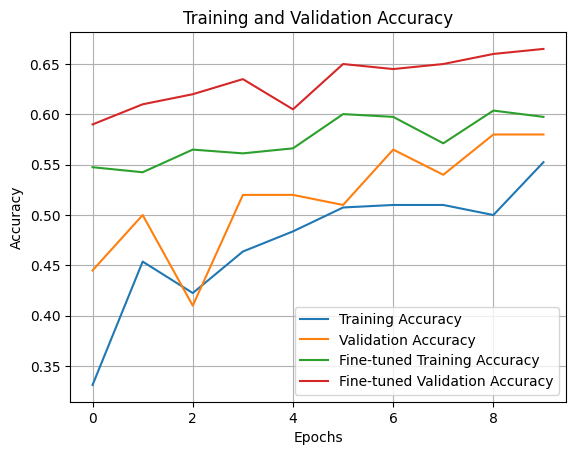

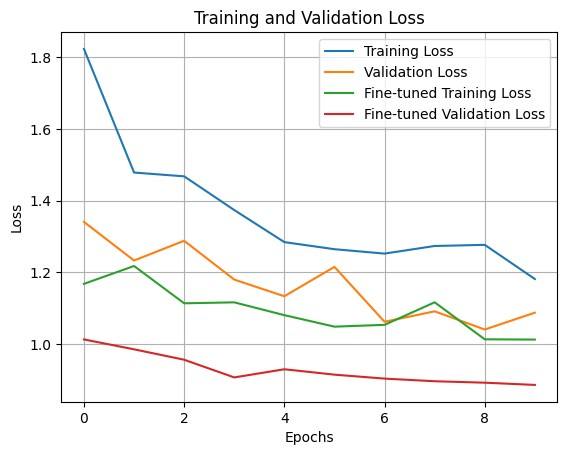

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

## Test model predictions on sample images and visualize results
`Explanation: ` Makes predictions on a few test images and displays them with the model's predicted class.

Class Index Mapping: {'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


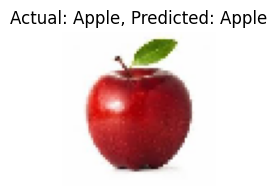

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


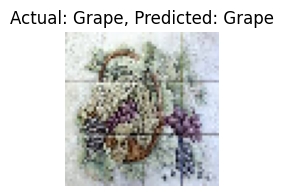

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


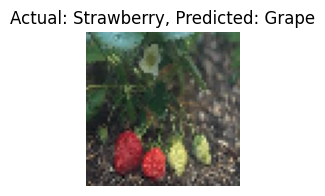

In [13]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'dataset/test/Apple/Apple (1750).jpeg',
    'dataset/test/Grape/Grape (567).jpeg',
    'dataset/test/Strawberry/Strawberry (635).jpeg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)

##### Explanation:
- `visualize_prediction: ` Loads an image, preprocesses it, predicts its class, and displays it.
- `model.predict(img_array): ` Uses the trained model to make predictions on unseen images.

## Saving the model

In [15]:
model.save('Fruit_Classifier_1o.h5')